## EDA Strategy for UA-DETRAC Vehicle Dataset

Our goal is to perform robust and interpretable exploratory data analysis (EDA) on the UA-DETRAC dataset. Instead of filtering or removing any videos, we focus on **understanding the structure and distribution of the data**, and **demonstrating a systematic analysis workflow** that could support downstream training and evaluation.

---

## EDA Workflow:

1. **Video Indexing**  
   - Load all training video identifiers from `RCNN_labels/train/*.pt`.  
   - Maintain a list (or dict) of video names for iterative analysis and visualization.

2. **Iterative Analysis and Quality Check**  
   For each video:  
   - Perform statistical checks and visual inspections to understand:  
     - Frame counts and video duration.  
     - Distribution of vehicle classes.  
     - Frame resolutions and lighting conditions.  
     - Annotation completeness and consistency.

3. **Dynamic Tracking (Optional)**  
   - While we do **not exclude** any data, we demonstrate how one **could flag** videos with unusual statistics (e.g., highly imbalanced class distribution, short length).  
   - This serves as a reference for dataset diagnostics in other scenarios.

4. **Descriptive Statistics and Visualization**  
   - Aggregate data across all videos to present:  
     - Vehicle class histograms.  
     - Traffic volume over time.  
     - Weather and lighting condition distributions (from annotation metadata).  
     - Sample frames for visual inspection.

5. **Downstream Relevance**  
   - This EDA process guides the design of training workflows and evaluation protocols.  
   - Ensures transparency in how the dataset is used and interpreted.

---

*By leveraging the rich annotations and diverse conditions in UA-DETRAC, this EDA approach emphasizes transparency, reproducibility, and provides actionable insights without modifying the training data itself.*

## 1.1 Get a list of training videos

In [2]:
import os
from glob import glob

# Get all training video IDs (remove the extension)
train_pt_dir = "RCNN_labels/train"
train_videos = [os.path.splitext(os.path.basename(f))[0] for f in glob(os.path.join(train_pt_dir, "*.pt"))]
print(len(train_videos))
print(train_videos) 

60
['MVI_20011', 'MVI_20012', 'MVI_20032', 'MVI_20033', 'MVI_20034', 'MVI_20035', 'MVI_20051', 'MVI_20052', 'MVI_20061', 'MVI_20062', 'MVI_20063', 'MVI_20064', 'MVI_20065', 'MVI_39761', 'MVI_39771', 'MVI_39781', 'MVI_39801', 'MVI_39811', 'MVI_39821', 'MVI_39851', 'MVI_39861', 'MVI_39931', 'MVI_40131', 'MVI_40141', 'MVI_40152', 'MVI_40161', 'MVI_40162', 'MVI_40171', 'MVI_40172', 'MVI_40181', 'MVI_40191', 'MVI_40192', 'MVI_40201', 'MVI_40204', 'MVI_40211', 'MVI_40212', 'MVI_40213', 'MVI_40241', 'MVI_40243', 'MVI_40244', 'MVI_40732', 'MVI_40751', 'MVI_40752', 'MVI_40871', 'MVI_40962', 'MVI_40963', 'MVI_40981', 'MVI_40991', 'MVI_40992', 'MVI_41063', 'MVI_41073', 'MVI_63521', 'MVI_63525', 'MVI_63544', 'MVI_63552', 'MVI_63553', 'MVI_63554', 'MVI_63561', 'MVI_63562', 'MVI_63563']


## 1.2 Check that all images are of the same resolution
* If an image does not meet the `960X540` resolution, we will remove the video corresponding to the image from the training dataset.

In [3]:
import os
import cv2
from glob import glob
from tqdm import tqdm

In [4]:
def check_image_resolution(image_dirs, expected_size=(960, 540)):
    
    abnormal_videos = set()
    all_images = []
    for img_dir in image_dirs:
        all_images.extend(glob(os.path.join(img_dir, "*.jpg")))

    for img_path in tqdm(all_images, desc="Checking image resolutions"):
        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w = img.shape[:2]
        if (w, h) != expected_size:
            base = os.path.basename(img_path)
            video_prefix = base.split("_img")[0]
            abnormal_videos.add(video_prefix)

    if abnormal_videos:
        print("❌ Videos with inconsistent image resolution:")
        for v in sorted(abnormal_videos):
            print(f" - {v}")
    else:
        print("✅ All video frames are 960×540")

In [5]:
check_image_resolution(["images/train", "images/test"])

Checking image resolutions: 100%|█████████████████████████████████████████████| 140131/140131 [09:26<00:00, 247.40it/s]

✅ All video frames are 960×540


### All images passed the check and no training videos needed to be removed.

## 1.3 Check the number of vehicles in each frame and analyze the congestion level
* We need to remove videos with empty frames or too much congestion. The default congestion threshold is 25, which can be adjusted freely.

In [14]:
import os
import torch
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

In [15]:
def count_vehicles_per_video(pt_dir="RCNN_labels/train", max_threshold=25):
    video_counts = {}
    abnormal_videos = set()

    pt_files = sorted(glob(os.path.join(pt_dir, "*.pt")))
    for pt_path in tqdm(pt_files, desc="Counting vehicles per video"):
        video_name = os.path.splitext(os.path.basename(pt_path))[0]
        data = torch.load(pt_path)
        vehicle_counts = [len(frame["objects"]) for frame in data]
        video_counts[video_name] = vehicle_counts

        # Anomaly detection: empty frame or exceeding threshold
        if any(v == 0 for v in vehicle_counts) or any(v > max_threshold for v in vehicle_counts):
            abnormal_videos.add(video_name)

    return video_counts, abnormal_videos

In [16]:
def plot_vehicle_counts(video_counts, videos_per_row=5):
    num_videos = len(video_counts)
    rows = (num_videos + videos_per_row - 1) // videos_per_row
    fig, axs = plt.subplots(rows, videos_per_row, figsize=(videos_per_row*4, rows*3))

    axs = axs.flatten()
    for idx, (video, counts) in enumerate(video_counts.items()):
        axs[idx].plot(counts, marker='o', markersize=2, linewidth=1)
        axs[idx].set_title(video, fontsize=8)
        axs[idx].set_xlabel("Frame", fontsize=6)
        axs[idx].set_ylabel("Vehicle Count", fontsize=6)
        axs[idx].tick_params(labelsize=6)

    for j in range(len(video_counts), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.suptitle("Vehicle Count per Frame (Train Videos)", fontsize=14, y=1.02)
    plt.show()

In [17]:
video_counts, abnormal_videos = count_vehicles_per_video("RCNN_labels/train", max_threshold=25)

Counting vehicles per video: 100%|█████████████████████████████████████████████████████| 60/60 [00:27<00:00,  2.21it/s]


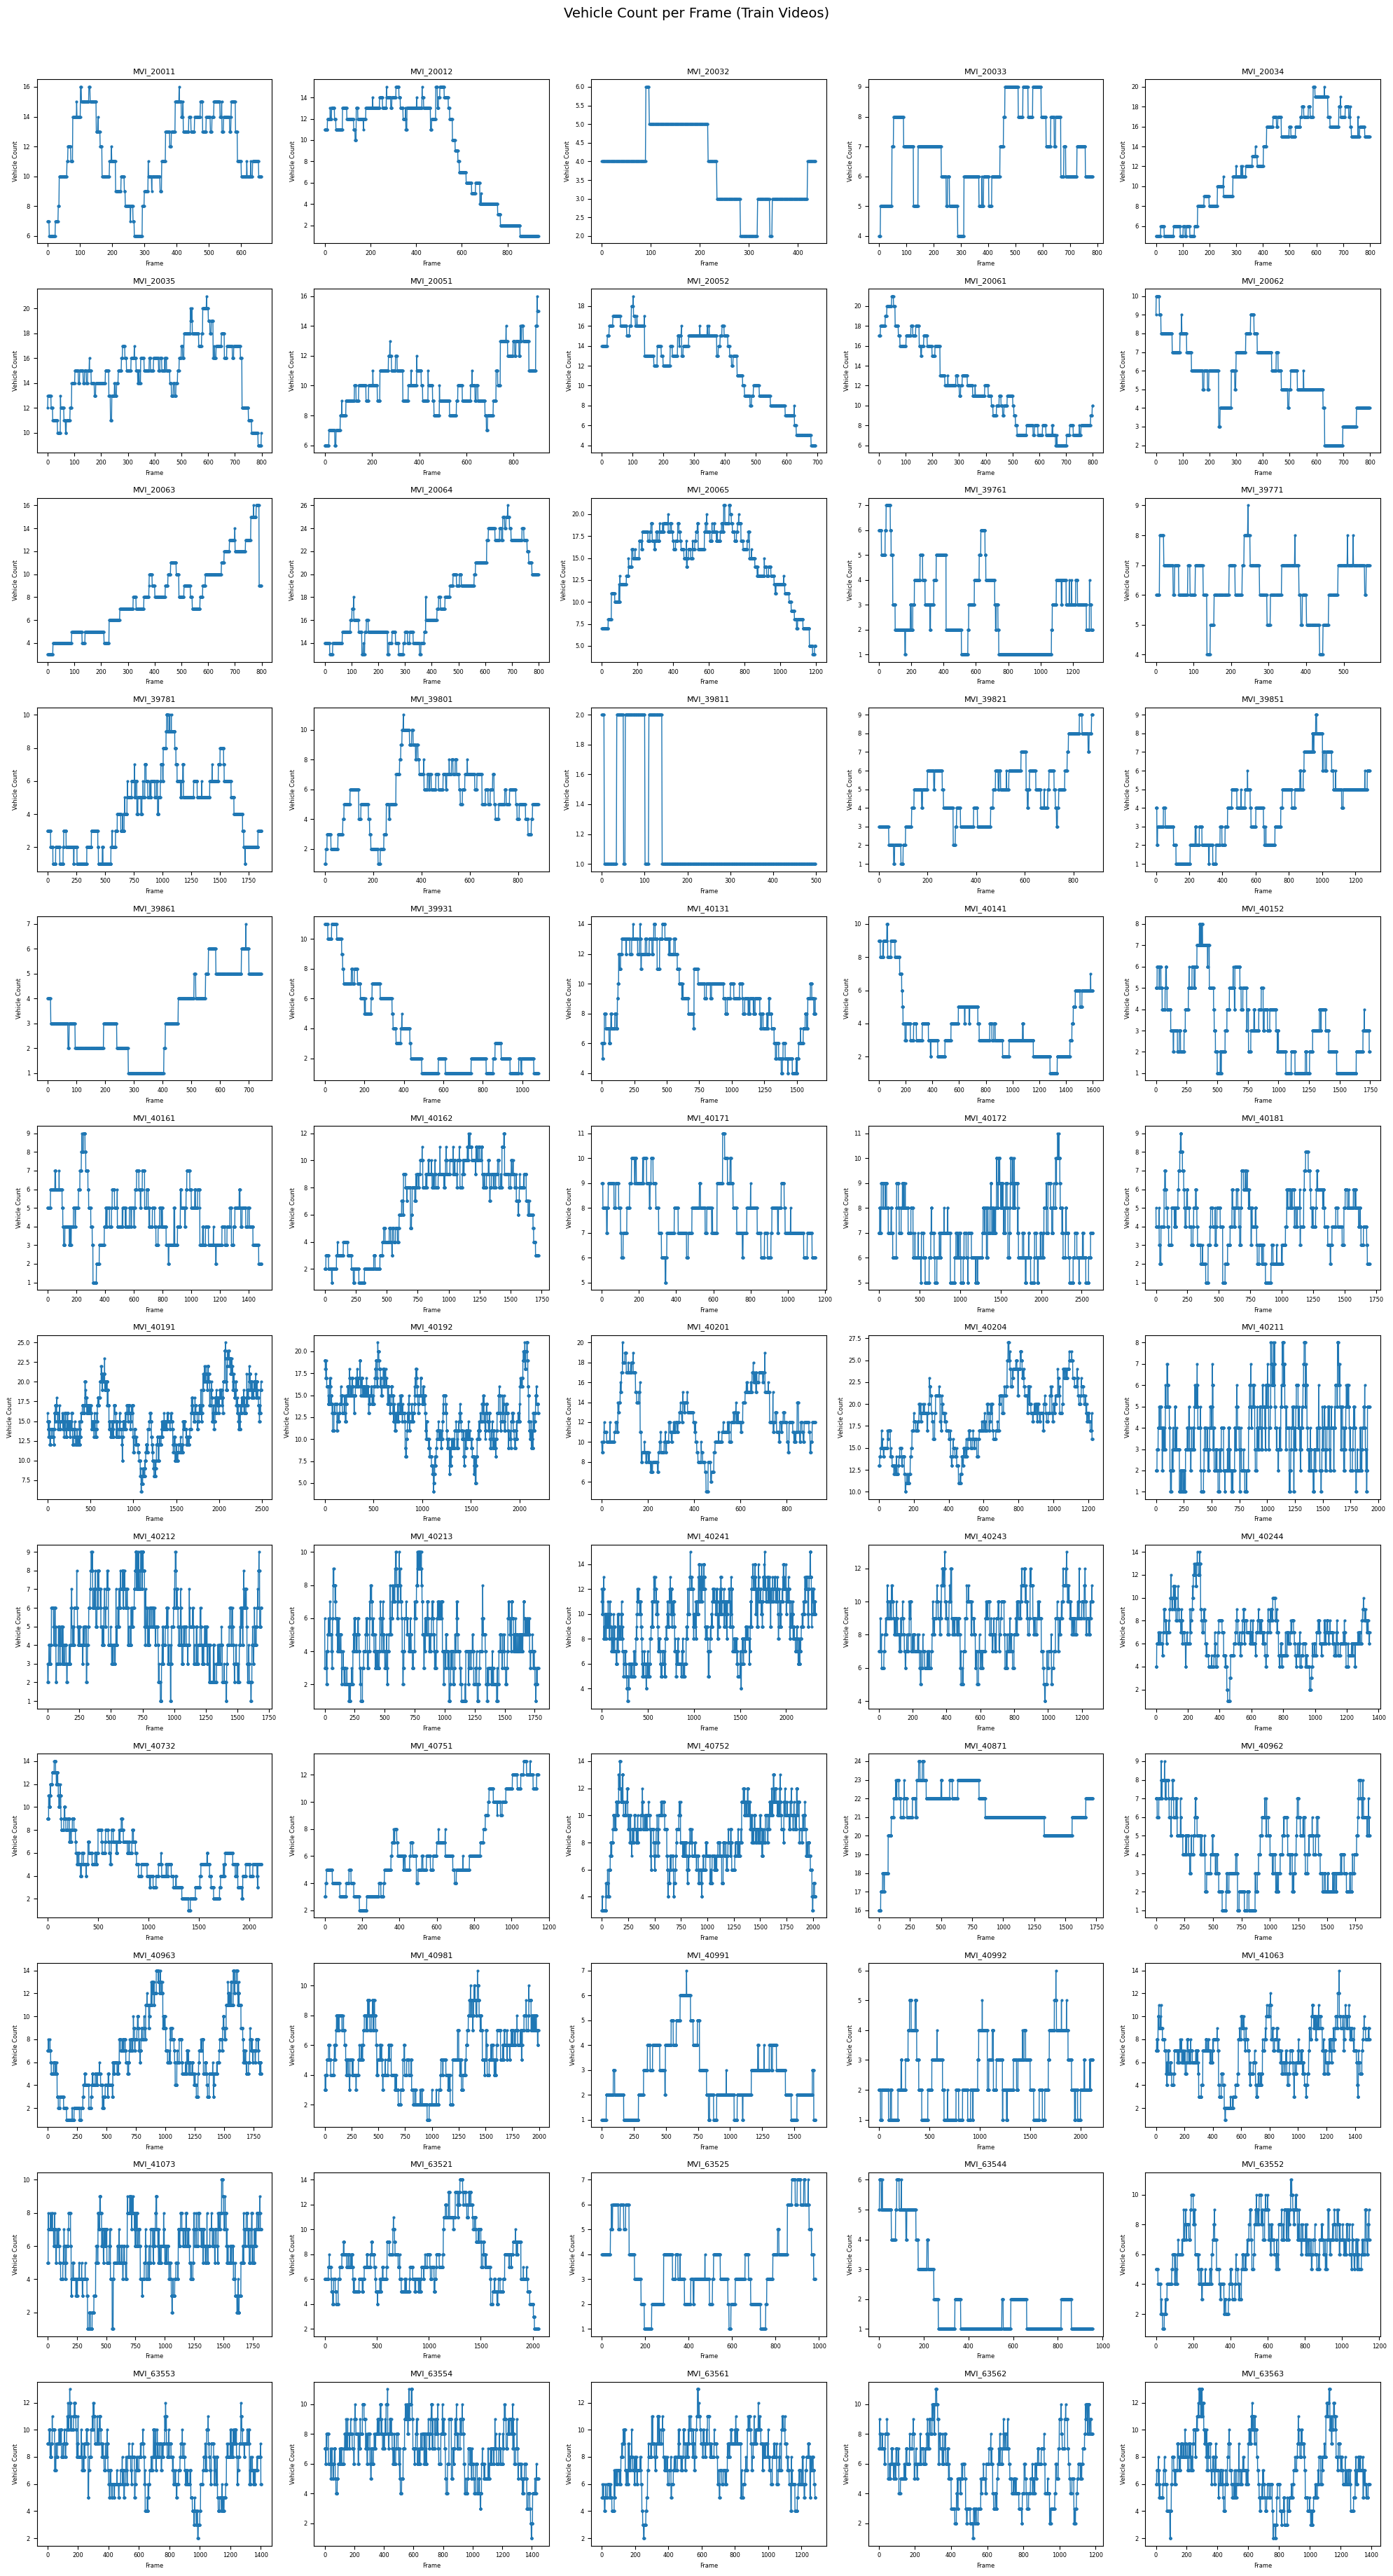

In [18]:
plot_vehicle_counts(video_counts)

In [19]:
print("Abnormal videos:")
for v in sorted(abnormal_videos):
    print(f" - {v}")

Abnormal videos:
 - MVI_20064
 - MVI_40204


### We found two abnormal videos, and their vehicle statistics are shown in detail below.

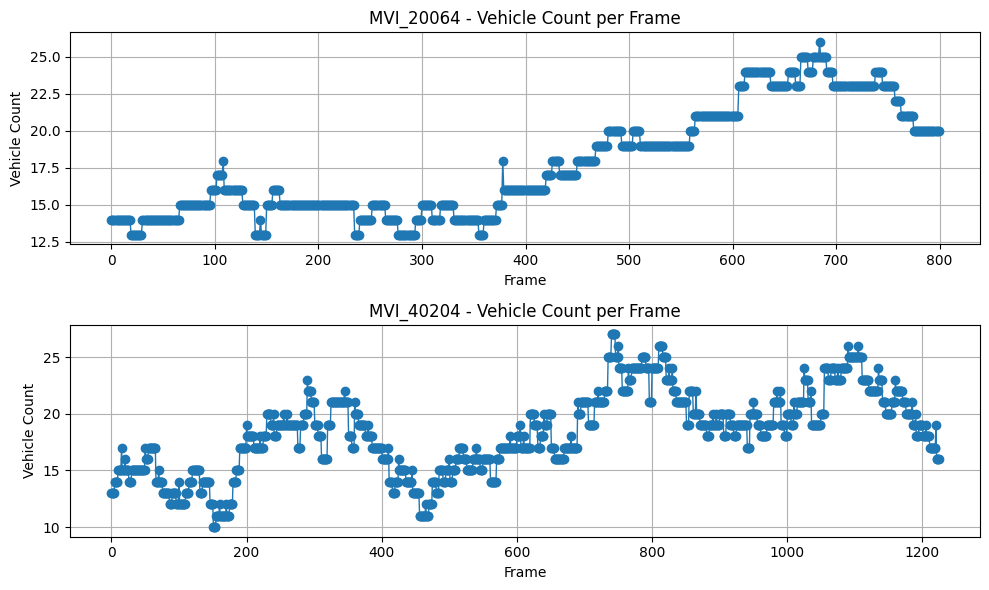

In [20]:
plt.figure(figsize=(10, 6))

# MVI_20064
plt.subplot(2, 1, 1)
plt.plot(video_counts["MVI_20064"], marker='o', linewidth=1)
plt.title("MVI_20064 - Vehicle Count per Frame")
plt.xlabel("Frame")
plt.ylabel("Vehicle Count")
plt.grid(True)

# MVI_40204
plt.subplot(2, 1, 2)
plt.plot(video_counts["MVI_40204"], marker='o', linewidth=1)
plt.title("MVI_40204 - Vehicle Count per Frame")
plt.xlabel("Frame")
plt.ylabel("Vehicle Count")
plt.grid(True)

plt.tight_layout()
plt.show()

### It was found that these two videos were too crowded (the number of vehicles exceeded 25), so they were removed from the training videos.

In [21]:
filtered_train_videos = [v for v in train_videos if v not in abnormal_videos]
# Print the number of videos remaining
print(f" Filtered training videos: {len(filtered_train_videos)} remain")
print(filtered_train_videos)

 Filtered training videos: 58 remain
['MVI_20011', 'MVI_20012', 'MVI_20032', 'MVI_20033', 'MVI_20034', 'MVI_20035', 'MVI_20051', 'MVI_20052', 'MVI_20061', 'MVI_20062', 'MVI_20063', 'MVI_20065', 'MVI_39761', 'MVI_39771', 'MVI_39781', 'MVI_39801', 'MVI_39811', 'MVI_39821', 'MVI_39851', 'MVI_39861', 'MVI_39931', 'MVI_40131', 'MVI_40141', 'MVI_40152', 'MVI_40161', 'MVI_40162', 'MVI_40171', 'MVI_40172', 'MVI_40181', 'MVI_40191', 'MVI_40192', 'MVI_40201', 'MVI_40211', 'MVI_40212', 'MVI_40213', 'MVI_40241', 'MVI_40243', 'MVI_40244', 'MVI_40732', 'MVI_40751', 'MVI_40752', 'MVI_40871', 'MVI_40962', 'MVI_40963', 'MVI_40981', 'MVI_40991', 'MVI_40992', 'MVI_41063', 'MVI_41073', 'MVI_63521', 'MVI_63525', 'MVI_63544', 'MVI_63552', 'MVI_63553', 'MVI_63554', 'MVI_63561', 'MVI_63562', 'MVI_63563']


## 1.4 Count the different types of vehicles that appear in each training video

In [29]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [30]:
def count_vehicle_types_from_xml(xml_dir="Train-Annotations"):
    vehicle_stats = {}       # video_name -> {car: X, bus: Y, ...}
    abnormal_videos = set()  # Videos containing only one vehicle type

    xml_files = sorted(glob(os.path.join(xml_dir, "*.xml")))
    for xml_path in tqdm(xml_files, desc="Counting vehicle types"):
        video_name = os.path.splitext(os.path.basename(xml_path))[0]
        tree = ET.parse(xml_path)
        root = tree.getroot()

        id2type = {}
        for frame_elem in root.findall("frame"):
            for target in frame_elem.find("target_list").findall("target"):
                tid = target.get("id")
                vtype = target.find("attribute").get("vehicle_type", "others").lower()
                if tid not in id2type:
                    id2type[tid] = vtype

        type_counter = defaultdict(int)
        for vtype in id2type.values():
            type_counter[vtype] += 1

        vehicle_stats[video_name] = dict(type_counter)

        # Tag videos of only one type
        if len(type_counter) == 1:
            abnormal_videos.add(video_name)

    return vehicle_stats, abnormal_videos

In [31]:
def plot_vehicle_type_distribution(vehicle_stats, types=["car", "bus", "van", "others"], videos_per_row=5):
    num_videos = len(vehicle_stats)
    rows = (num_videos + videos_per_row - 1) // videos_per_row

    fig, axs = plt.subplots(rows, videos_per_row, figsize=(videos_per_row*4, rows*3))
    axs = axs.flatten()

    for idx, (video, counts) in enumerate(vehicle_stats.items()):
        y = [counts.get(t, 0) for t in types]
        axs[idx].bar(types, y)
        axs[idx].set_title(video, fontsize=8)
        axs[idx].tick_params(labelsize=6)

    for j in range(len(vehicle_stats), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.suptitle("Vehicle Type Distribution per Video", fontsize=14, y=1.02)
    plt.show()

In [32]:
vehicle_stats, abnormal_videos = count_vehicle_types_from_xml("Train-Annotations")

Counting vehicle types: 100%|██████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.59it/s]


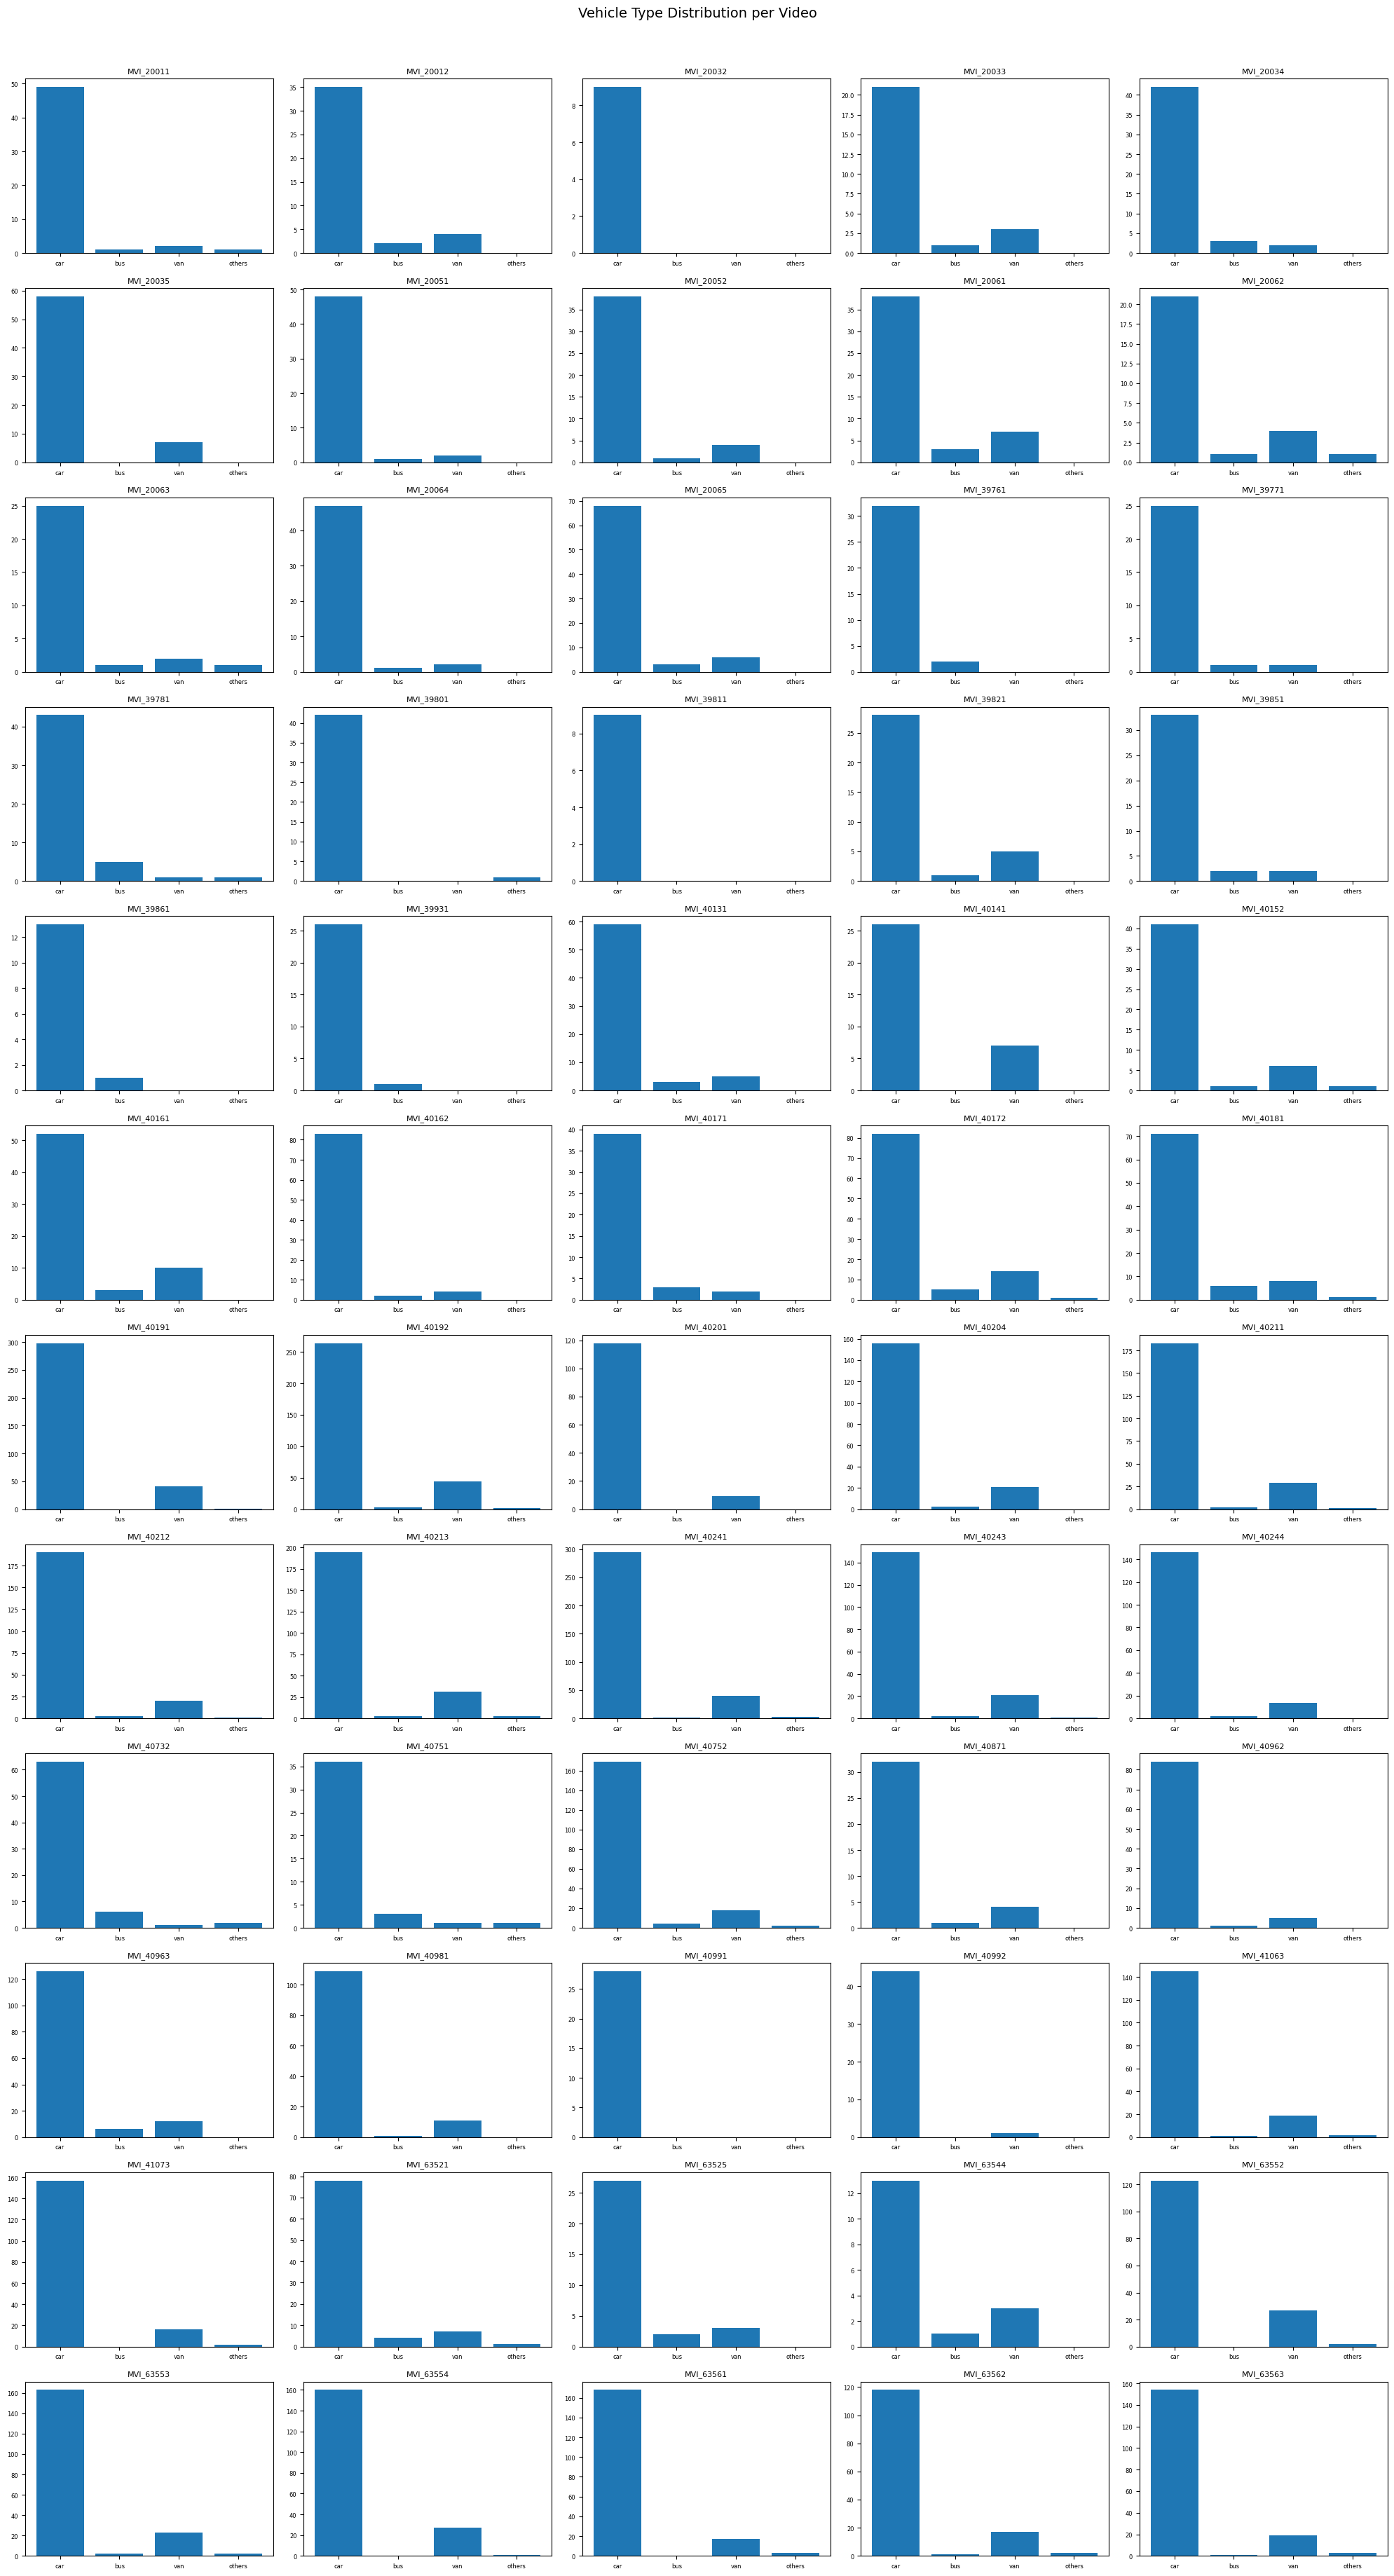

In [33]:
plot_vehicle_type_distribution(vehicle_stats)

In [35]:
print(" Videos with only one vehicle type:")
for v in sorted(abnormal_videos):
    print(f" - {v}")

 Videos with only one vehicle type:
 - MVI_20032
 - MVI_39811
 - MVI_40991


### Videos with only one type of vehicle are unbalanced data and need to be removed from the training videos.

In [37]:
# Further remove such abnormal videos
filtered_train_videos = [v for v in filtered_train_videos if v not in abnormal_videos]

# Printing Results
print(f" Filtered training videos after further removals: {len(filtered_train_videos)} remain")
print(filtered_train_videos)  

 Filtered training videos after further removals: 55 remain
['MVI_20011', 'MVI_20012', 'MVI_20033', 'MVI_20034', 'MVI_20035', 'MVI_20051', 'MVI_20052', 'MVI_20061', 'MVI_20062', 'MVI_20063', 'MVI_20065', 'MVI_39761', 'MVI_39771', 'MVI_39781', 'MVI_39801', 'MVI_39821', 'MVI_39851', 'MVI_39861', 'MVI_39931', 'MVI_40131', 'MVI_40141', 'MVI_40152', 'MVI_40161', 'MVI_40162', 'MVI_40171', 'MVI_40172', 'MVI_40181', 'MVI_40191', 'MVI_40192', 'MVI_40201', 'MVI_40211', 'MVI_40212', 'MVI_40213', 'MVI_40241', 'MVI_40243', 'MVI_40244', 'MVI_40732', 'MVI_40751', 'MVI_40752', 'MVI_40871', 'MVI_40962', 'MVI_40963', 'MVI_40981', 'MVI_40992', 'MVI_41063', 'MVI_41073', 'MVI_63521', 'MVI_63525', 'MVI_63544', 'MVI_63552', 'MVI_63553', 'MVI_63554', 'MVI_63561', 'MVI_63562', 'MVI_63563']


## 1.5 Analyze the trajectory_length distribution of the vehicle in each video

In [41]:
from collections import defaultdict
import xml.etree.ElementTree as ET
from glob import glob
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [47]:
def analyze_trajectory_length(xml_dir="Train-Annotations"):
    traj_stats = {}  # video_name -> list of trajectory_lengths

    xml_files = sorted(glob(os.path.join(xml_dir, "*.xml")))
    for xml_path in tqdm(xml_files, desc="Analyzing trajectory length"):
        video_name = os.path.splitext(os.path.basename(xml_path))[0]
        tree = ET.parse(xml_path)
        root = tree.getroot()

        id2traj = {}
        for frame in root.findall("frame"):
            for target in frame.find("target_list").findall("target"):
                tid = target.get("id")
                attr = target.find("attribute")
                if tid not in id2traj:
                    traj_len = int(attr.get("trajectory_length", 0))
                    id2traj[tid] = traj_len

        traj_stats[video_name] = list(id2traj.values())

    return traj_stats

In [43]:
def plot_trajectory_length_distribution(traj_stats, videos_per_row=5):
    num_videos = len(traj_stats)
    rows = (num_videos + videos_per_row - 1) // videos_per_row
    fig, axs = plt.subplots(rows, videos_per_row, figsize=(videos_per_row*4, rows*3))
    axs = axs.flatten()

    for idx, (video, traj_list) in enumerate(traj_stats.items()):
        axs[idx].hist(traj_list, bins=10, range=(0, max(traj_list)+1), color='skyblue')
        axs[idx].set_title(video, fontsize=8)
        axs[idx].set_xlabel("Trajectory Length", fontsize=6)
        axs[idx].set_ylabel("Vehicle Count", fontsize=6)
        axs[idx].tick_params(labelsize=6)

    for j in range(len(traj_stats), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.suptitle("Trajectory Length Distribution per Video", fontsize=14, y=1.02)
    plt.show()

Analyzing trajectory length: 100%|█████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.63it/s]


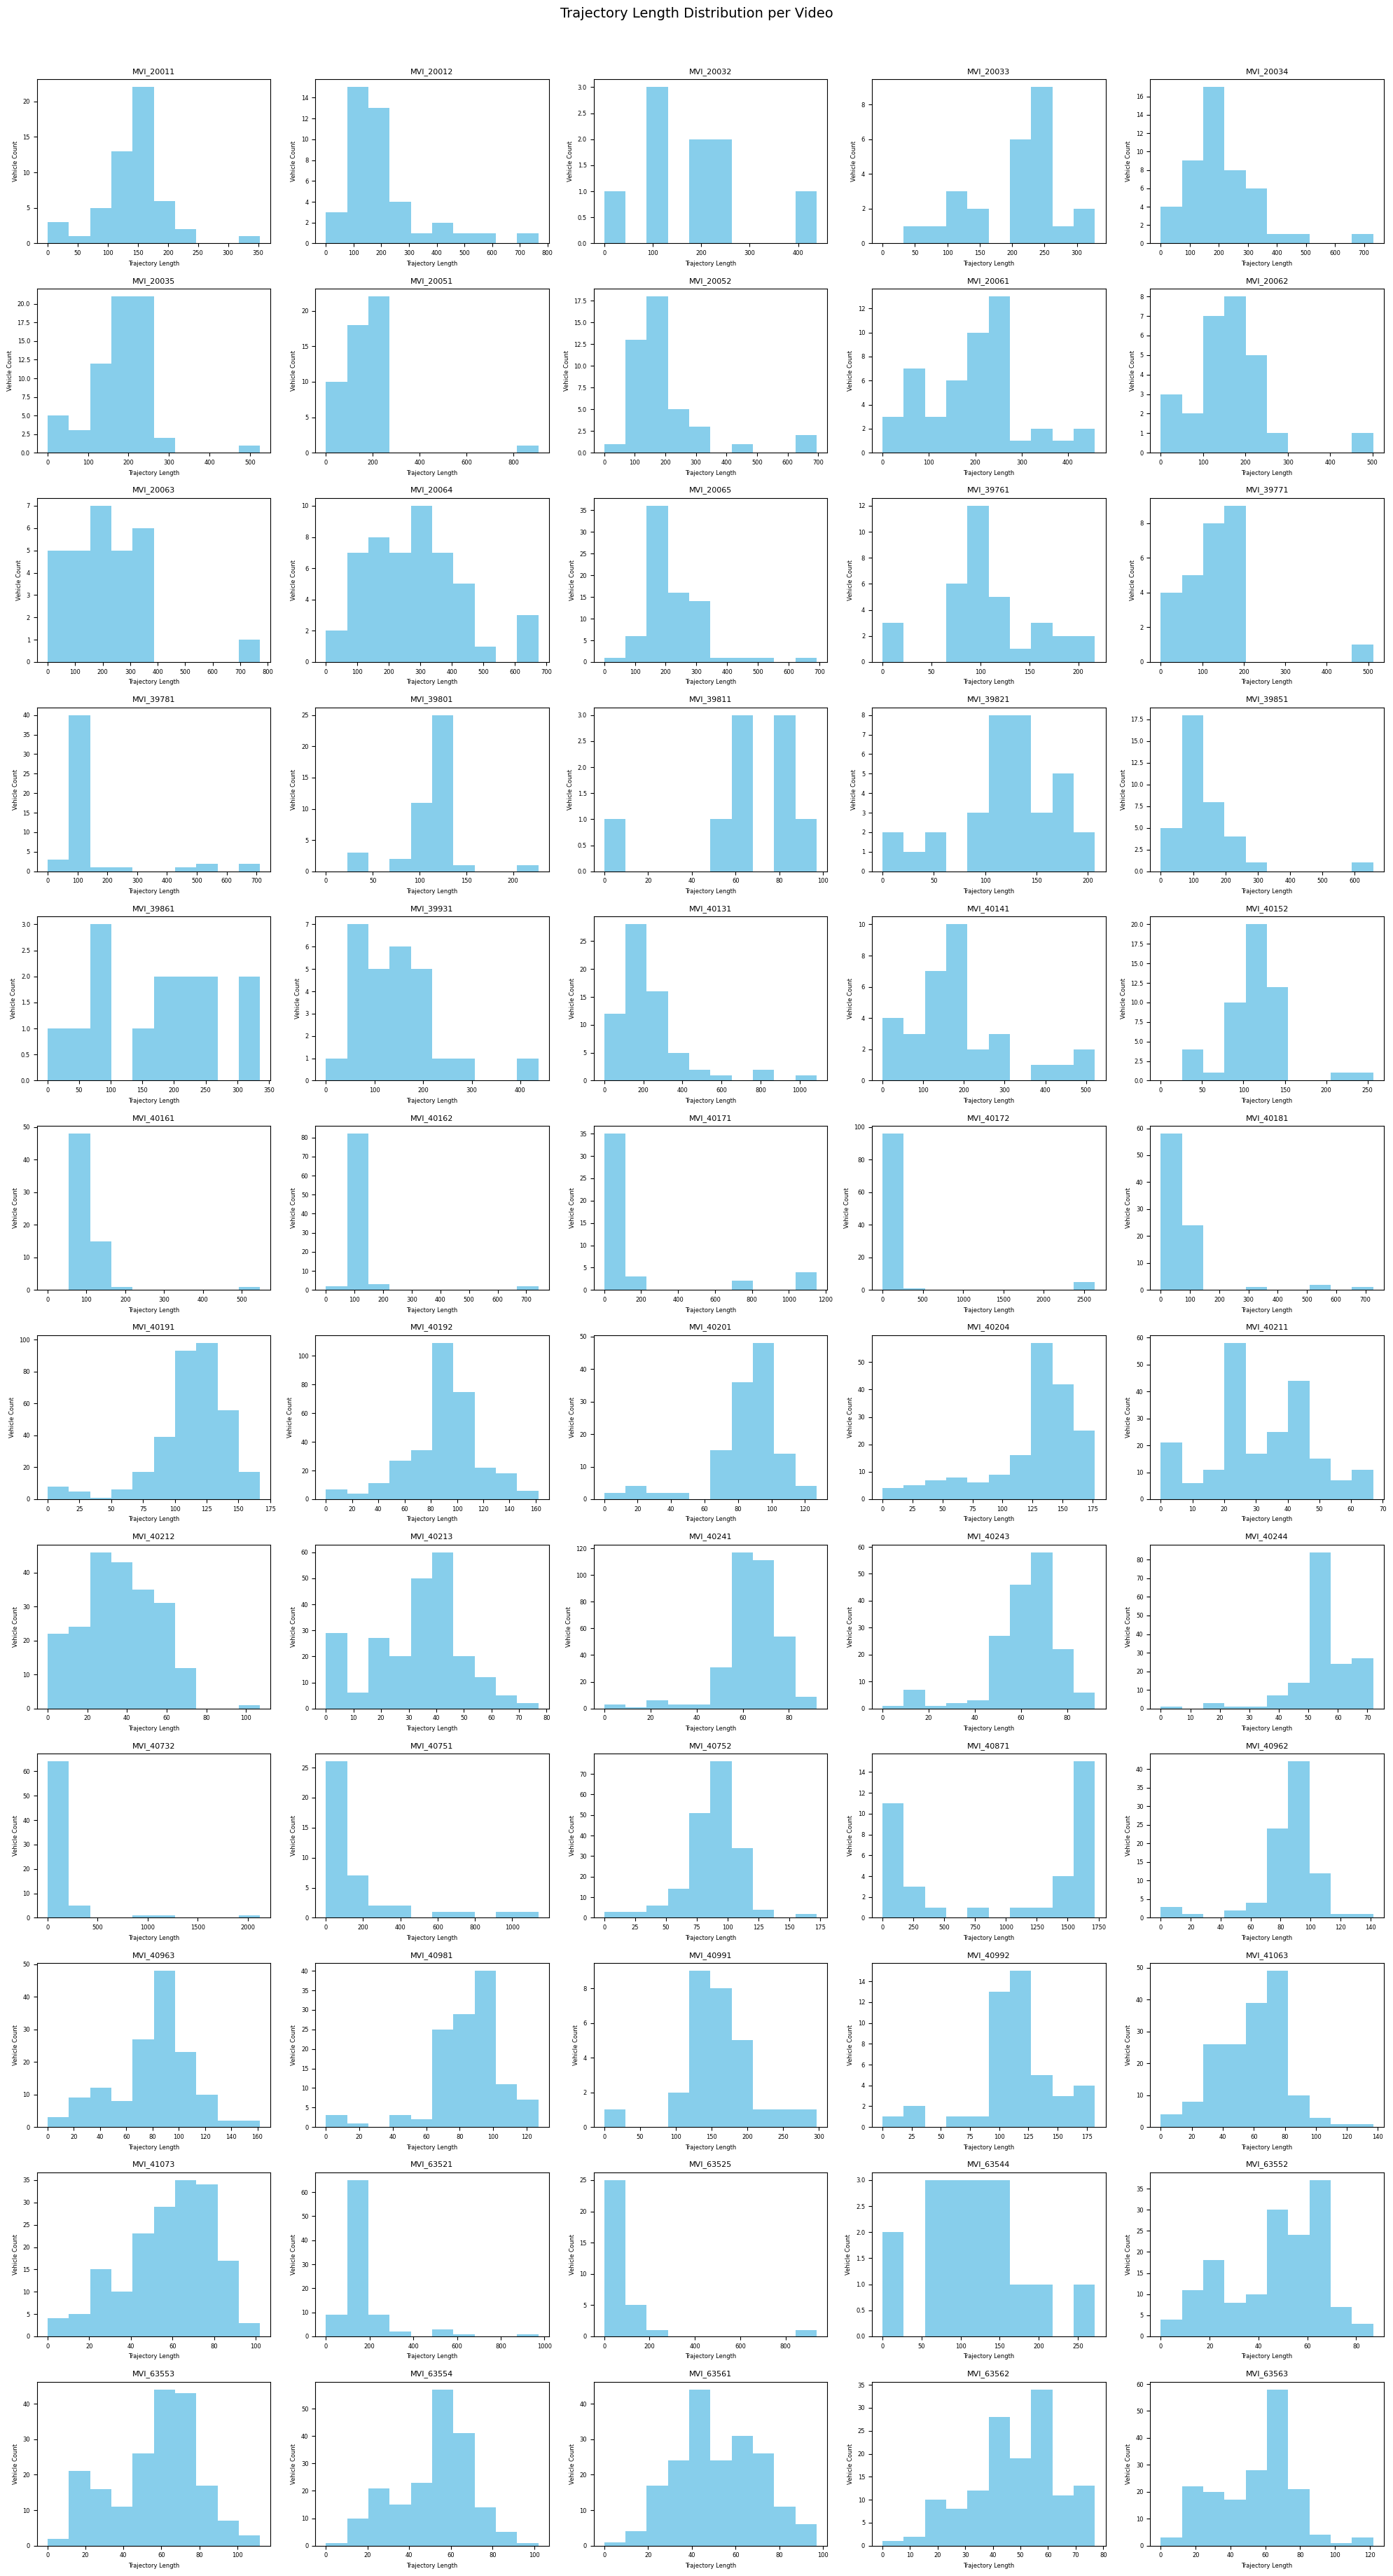

In [48]:
traj_stats = analyze_trajectory_length("Train-Annotations")
plot_trajectory_length_distribution(traj_stats)

## 1.6 Bounding box size distribution 
* Check whether there are very small or large box outliers

In [49]:
def collect_bbox_areas_per_video(pt_dir="RCNN_labels/train"):
    video_areas = {}  # video_name -> list of areas

    pt_files = sorted(glob(os.path.join(pt_dir, "*.pt")))
    for pt_file in tqdm(pt_files, desc="Collecting bbox areas per video"):
        video_name = os.path.splitext(os.path.basename(pt_file))[0]
        data = torch.load(pt_file)
        areas = []
        for frame in data:
            for obj in frame["objects"]:
                box = obj["bndbox"]
                w = box["xmax"] - box["xmin"]
                h = box["ymax"] - box["ymin"]
                area = w * h
                areas.append(area)
        video_areas[video_name] = areas

    return video_areas

In [50]:
def plot_bbox_area_per_video(video_areas, videos_per_row=5):
    num_videos = len(video_areas)
    rows = (num_videos + videos_per_row - 1) // videos_per_row

    fig, axs = plt.subplots(rows, videos_per_row, figsize=(videos_per_row * 4, rows * 3))
    axs = axs.flatten()

    for idx, (video, areas) in enumerate(video_areas.items()):
        axs[idx].hist(areas, bins=30, color='lightblue')
        axs[idx].set_title(video, fontsize=8)
        axs[idx].set_xlabel("Area", fontsize=6)
        axs[idx].set_ylabel("Count", fontsize=6)
        axs[idx].tick_params(labelsize=6)

    for j in range(len(video_areas), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.suptitle("Bounding Box Area Distribution per Video", fontsize=14, y=1.02)
    plt.show()

In [51]:
video_areas = collect_bbox_areas_per_video("RCNN_labels/train")

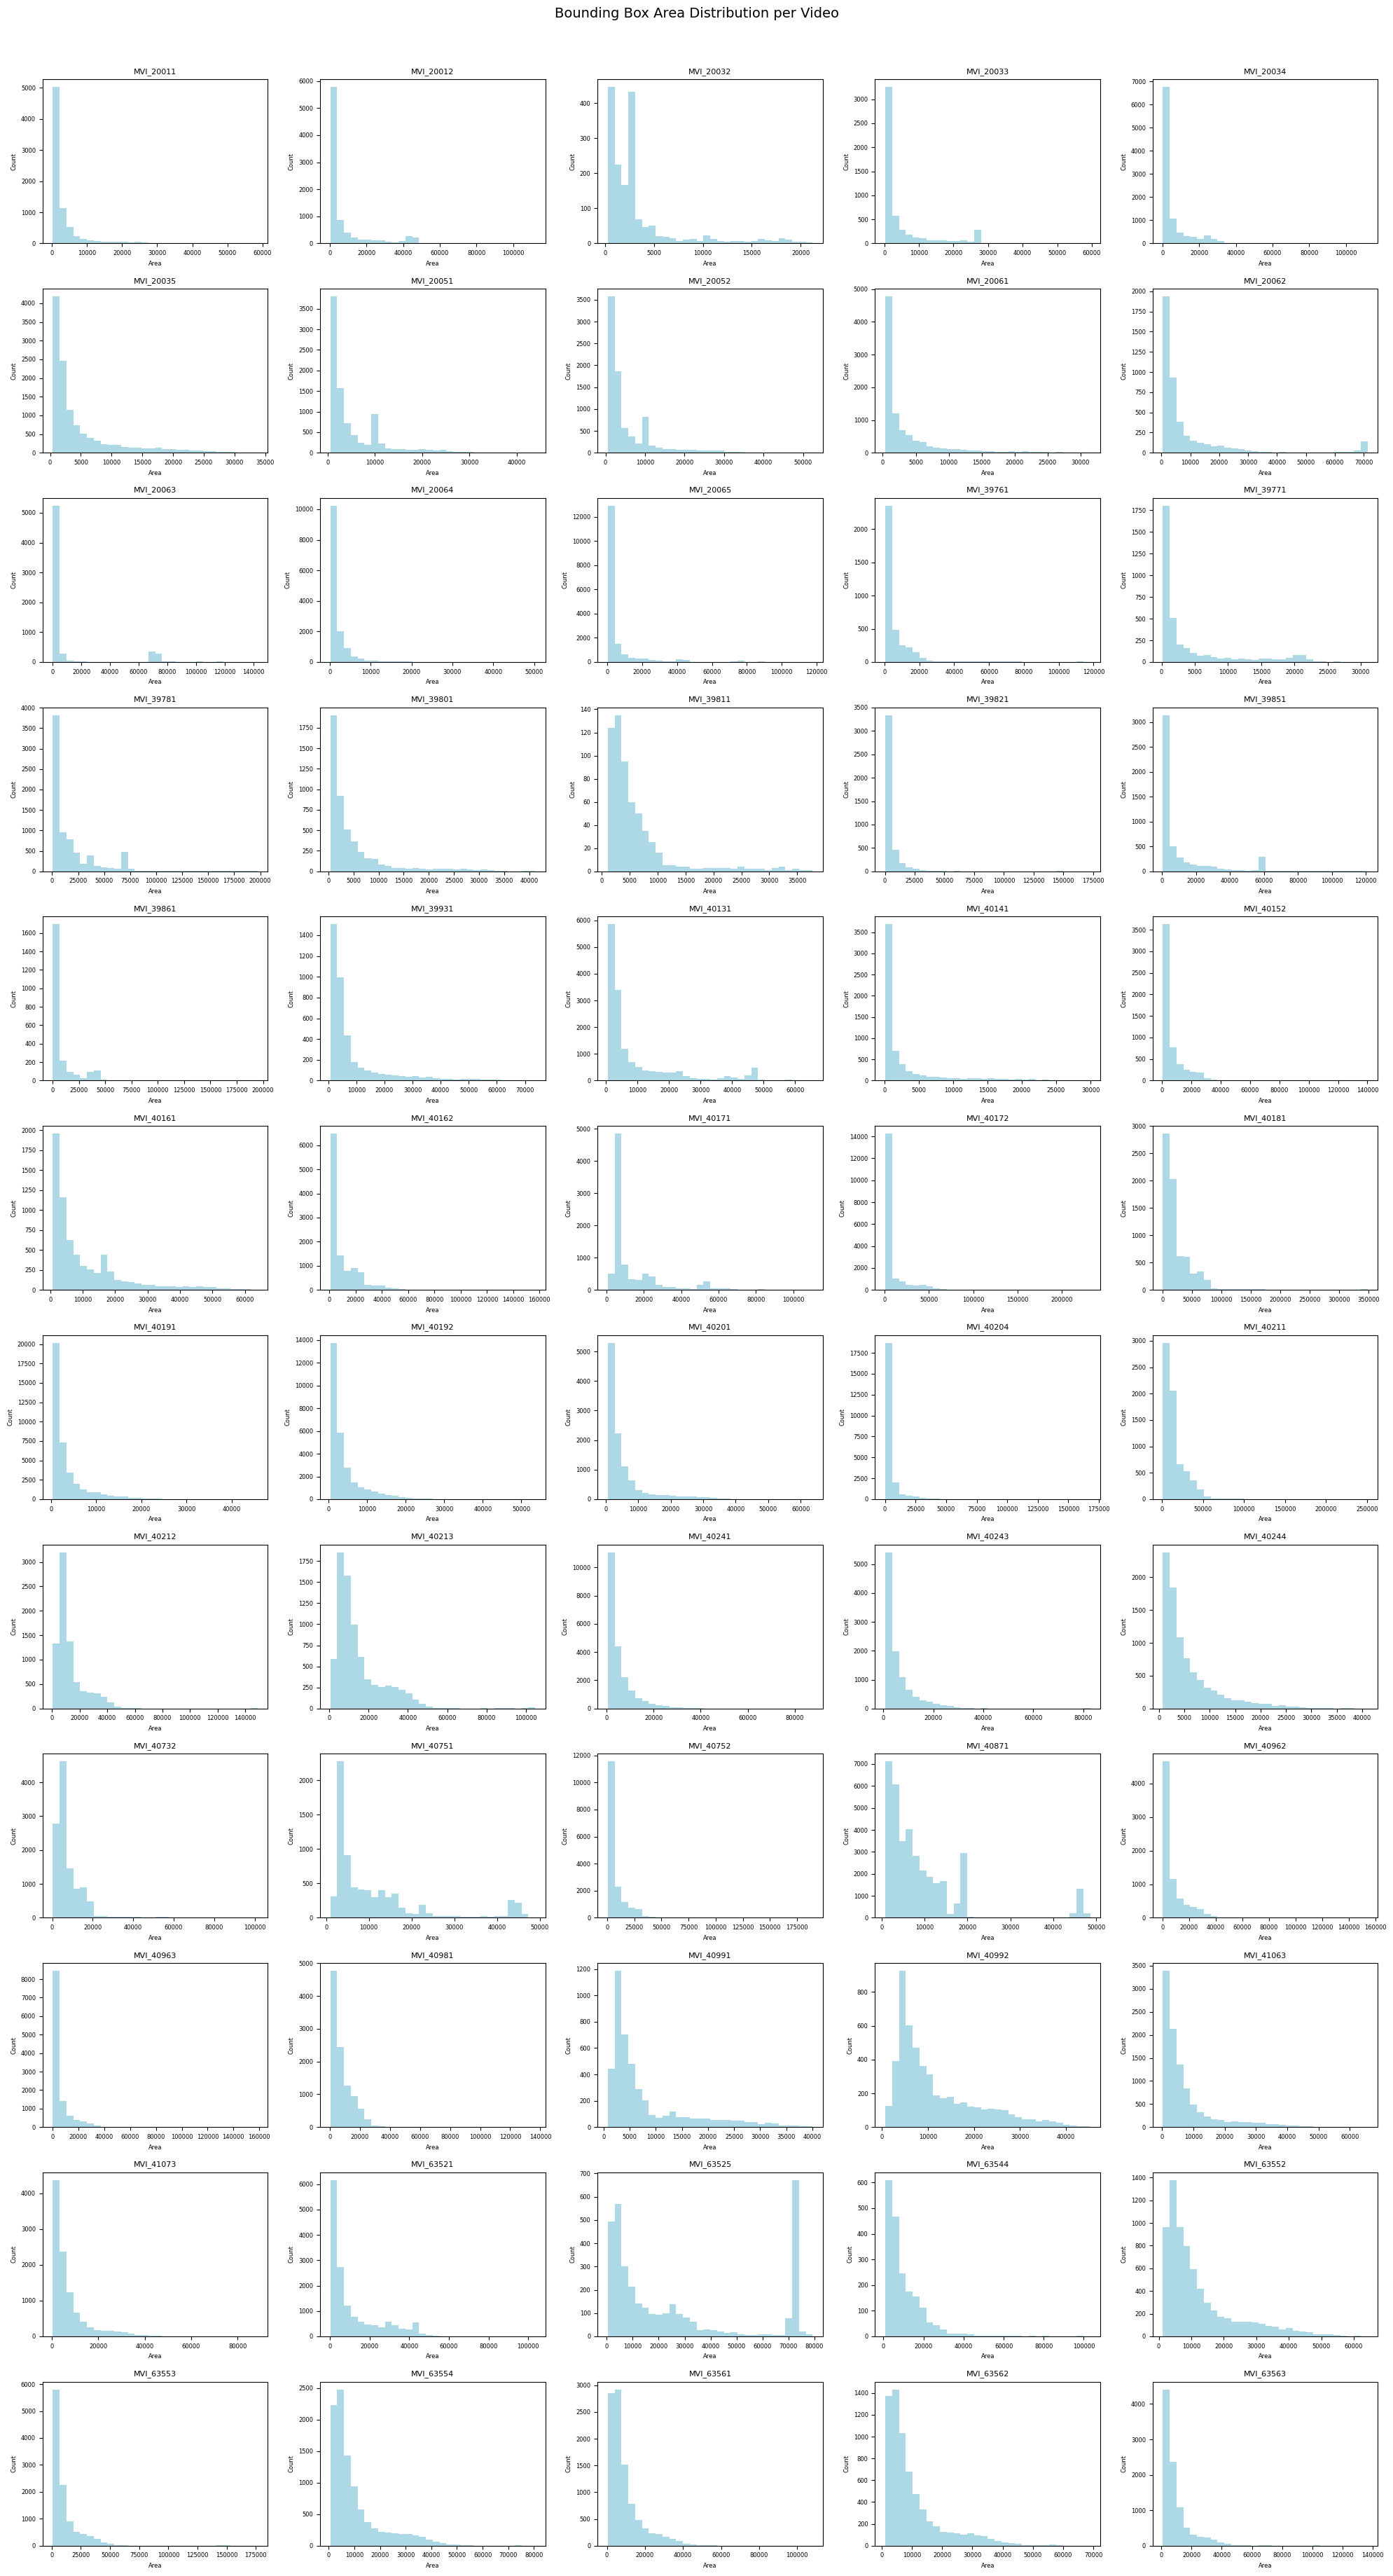

In [52]:
plot_bbox_area_per_video(video_areas)

## 2. Save the filtered train video to a txt file

In [53]:
with open("train_list.txt", "w") as f:
    f.writelines([v + "\n" for v in filtered_train_videos])